In [93]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Steps

Step#1 Computes mean vectors of each class of dependent variable

Step#2 Computers with-in class and between-class scatter matrices

Step#3 Computes eigenvalues and eigenvector for SW(Scatter matrix within class) and SB (scatter matrix between class)

Step#4 Sorts the eigenvalues in descending order and select the top k

Step#5 Creates a new matrix containing eigenvectors that map to the k eigenvalues

Step#6 Obtains the new features (i.e. linear discriminants) by taking the dot product of the data and the matrix. 

Compute the within class and between class scatter matrices

Compute the eigenvectors and corresponding eigenvalues for the scatter matrices

Sort the eigenvalues and select the top k

Create a new matrix containing eigenvectors that map to the k eigenvalues

Obtain the new features (i.e. LDA components) by taking the dot product of the data and the matrix from step 4

## Data

In [56]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)
X['class']=y

In [57]:
X.shape

(178, 14)

In [58]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


In [59]:
#class feature means
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in X.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


In [60]:
#or oneliner
X.groupby('class').mean().T

class,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


In [61]:
class_feature_means.shape

(13, 3)

In [62]:
#class mean
class_means=X.groupby('class').mean()
class_means.shape

(3, 13)

In [63]:
rows.mean()

alcohol                          13.153750
malic_acid                        3.333750
ash                               2.437083
alcalinity_of_ash                21.416667
magnesium                        99.312500
total_phenols                     1.678750
flavanoids                        0.781458
nonflavanoid_phenols              0.447500
proanthocyanins                   1.153542
color_intensity                   7.396250
hue                               0.682708
od280/od315_of_diluted_wines      1.683542
proline                         629.895833
dtype: float64

#### within class scatter

In [64]:
#within class scatter matrix
within_class_scatter_matrix = np.zeros((class_feature_means.shape[0],class_feature_means.shape[0]))

for c, rows in X.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((class_feature_means.shape[0],class_feature_means.shape[0]))
    for index, row in rows.iterrows():
            x = row.values.reshape(class_feature_means.shape[0],1)
            mc = class_feature_means[c].values.reshape(class_feature_means.shape[0],1)

            s += (x - mc)@((x - mc).T)

    within_class_scatter_matrix += s

In [65]:
within_class_scatter_matrix[0]

array([ 4.58591821e+01,  1.43027601e+00, -2.32911012e+00, -1.70130181e+01,
        3.13827137e+00,  4.74217613e+00,  3.96054915e+00, -1.70720423e-01,
        2.93497768e+00,  4.31301457e+01,  1.36868361e-01, -8.72438861e-01,
        2.14149506e+03])

In [66]:
within_class_scatter_matrix = np.zeros((class_feature_means.shape[0],class_feature_means.shape[0]))

for c, rows in X.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((class_feature_means.shape[0],class_feature_means.shape[0]))
    for index, row in rows.iterrows():
            x = row.values.reshape(class_feature_means.shape[0],1)
            mc = class_feature_means[c].values.reshape(class_feature_means.shape[0],1)

            s += (x - mc)@((x - mc).T)

    within_class_scatter_matrix += s

In [67]:
within_class_scatter_matrix.shape

(13, 13)

In [68]:
class_feature_means[c].values.reshape(1,-1).shape

(1, 13)

In [69]:
class_feature_means[c]

alcohol                          13.153750
malic_acid                        3.333750
ash                               2.437083
alcalinity_of_ash                21.416667
magnesium                        99.312500
total_phenols                     1.678750
flavanoids                        0.781458
nonflavanoid_phenols              0.447500
proanthocyanins                   1.153542
color_intensity                   7.396250
hue                               0.682708
od280/od315_of_diluted_wines      1.683542
proline                         629.895833
Name: class_2, dtype: float64

In [70]:
# a bit more compact version
within_class_scatter_matrix2 = np.zeros((class_feature_means.shape[0],class_feature_means.shape[0]))

for c, rows in X.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    mean_subtracted=rows-class_feature_means[c].values.reshape(1,-1)
    s=np.inner(mean_subtracted.T, mean_subtracted.T)
    within_class_scatter_matrix2 += s

In [71]:
within_class_scatter_matrix2[0]

array([ 4.58591821e+01,  1.43027601e+00, -2.32911012e+00, -1.70130181e+01,
        3.13827137e+00,  4.74217613e+00,  3.96054915e+00, -1.70720423e-01,
        2.93497768e+00,  4.31301457e+01,  1.36868361e-01, -8.72438861e-01,
        2.14149506e+03])

In [72]:
within_class_scatter_matrix[0]

array([ 4.58591821e+01,  1.43027601e+00, -2.32911012e+00, -1.70130181e+01,
        3.13827137e+00,  4.74217613e+00,  3.96054915e+00, -1.70720423e-01,
        2.93497768e+00,  4.31301457e+01,  1.36868361e-01, -8.72438861e-01,
        2.14149506e+03])

In [73]:
np.allclose(within_class_scatter_matrix, within_class_scatter_matrix2)

True

#### between class scatter

In [74]:
#feature means
feature_means=X.mean()
feature_means

alcohol                          13.000618
malic_acid                        2.336348
ash                               2.366517
alcalinity_of_ash                19.494944
magnesium                        99.741573
total_phenols                     2.295112
flavanoids                        2.029270
nonflavanoid_phenols              0.361854
proanthocyanins                   1.590899
color_intensity                   5.058090
hue                               0.957449
od280/od315_of_diluted_wines      2.611685
proline                         746.893258
dtype: float64

In [75]:
between_class_scatter_matrix = np.zeros((13,13))
for c in class_feature_means:    
    n = len(X.loc[X['class'] == c].index)
    
    mc = class_feature_means[c].values.reshape(13,1)
    m = feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m)@((mc - m).T)

In [76]:
between_class_scatter_matrix[0]

array([ 7.07948499e+01,  1.37229257e+01,  1.06684933e+01, -1.31860426e+02,
        5.52620156e+02,  2.12568615e+01,  3.00293312e+01, -2.61778351e+00,
        8.30762344e+00,  1.38875865e+02, -2.49334780e+00,  8.25295347e+00,
        2.69868967e+04])

#### eigenvectors and values of scatter matrices

In [77]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix)@between_class_scatter_matrix)

In [78]:
#sort them with values
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

9.081739435042476
4.128469045639485
1.016360546929593e-15
5.53972430432114e-16
4.582481649122134e-16
4.582481649122134e-16
3.1457218773888784e-16
3.1457218773888784e-16
2.5151867597685e-16
2.5151867597685e-16
2.5151587937748984e-16
3.477169693675181e-17
0.0


In [79]:
len(eigen_vectors[0])

13

In [80]:
pairs[0]

(9.081739435042476,
 array([-0.14368315+0.j,  0.05886047+0.j, -0.13145742+0.j,  0.055136  +0.j,
        -0.0007706 +0.j,  0.22013812+0.j, -0.59168399+0.j, -0.53278142+0.j,
         0.04776118+0.j,  0.12646393+0.j, -0.29136853+0.j, -0.41230012+0.j,
        -0.00095856+0.j]))

In [81]:
#another way to sort
idx=np.abs(eigen_values).argsort()[::-1]
pairs2=list(zip(eigen_values[idx], eigen_vectors[idx,:]))

In [82]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.6874788878860785
Eigenvector 1: 0.31252111211392164
Eigenvector 2: 7.693750998826968e-17
Eigenvector 3: 4.193517696879799e-17
Eigenvector 4: 3.468894269021839e-17
Eigenvector 5: 3.468894269021839e-17
Eigenvector 6: 2.3812810236788065e-17
Eigenvector 7: 2.3812810236788065e-17
Eigenvector 8: 1.9039720405976946e-17
Eigenvector 9: 1.9039720405976946e-17
Eigenvector 10: 1.903950870611133e-17
Eigenvector 11: 2.632183813571182e-18
Eigenvector 12: 0.0


#### create matrix W and LDA features

In [83]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real

In [84]:
w_matrix

array([[-1.43683152e-01, -2.54446951e-01],
       [ 5.88604714e-02, -8.91300292e-02],
       [-1.31457424e-01, -6.84674307e-01],
       [ 5.51359957e-02,  4.27236012e-02],
       [-7.70595267e-04,  1.35062989e-04],
       [ 2.20138120e-01,  9.40183328e-03],
       [-5.91683992e-01,  1.43597614e-01],
       [-5.32781421e-01,  4.76020325e-01],
       [ 4.77611849e-02,  8.96284915e-02],
       [ 1.26463935e-01, -7.39094841e-02],
       [-2.91368531e-01,  4.42362517e-01],
       [-4.12300124e-01, -1.49388710e-02],
       [-9.58555352e-04, -8.32689851e-04]])

In [85]:
X_lda = np.array(X.iloc[:,:-1]@w_matrix)

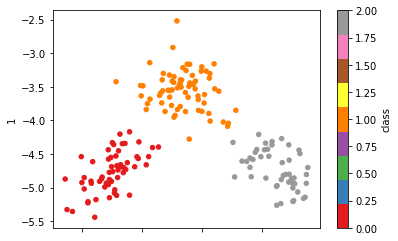

In [86]:
df_lda=pd.DataFrame(X_lda)
df_lda['class']=X['class'].astype('category').cat.codes
df_lda.plot.scatter(x=0, y=1, c='class', colormap='Set1')

In [116]:
X_lda[:5]

array([[-4.96196204, -4.85120862],
       [-4.82010035, -4.61516896],
       [-4.50622031, -4.69067141],
       [-4.7858342 , -5.44186796],
       [-3.82565267, -4.405262  ]])

## turn it into a function

In [88]:
def lda(x, y, n_eigens=2):
    df_x=pd.DataFrame(x)
    df_x['class_']=y

    class_f_means=df_x.groupby('class_').mean().T
    class_means=df_x.groupby('class_').mean()
    within_class_scatter_matrix=within_scatter(df_x, class_f_means)
    between_class_scatter_matrix=between_scatter(df_x, class_f_means)
    
    eigen_vecs=get_sorted_eigenvecs(within_class_scatter_matrix, between_class_scatter_matrix, 
                                  top_eigs=n_eigens)
    n_features=class_f_means.shape[0]
    w_matrix=eigen_vecs[:n_eigens,:].transpose().real
    df_x=df_x.drop('class_', axis=1)
    print(f'w_matrix shape {w_matrix.shape}')
    df_x_lda = pd.DataFrame(df_x@w_matrix)
    df_x_lda['class']=y
    return df_x_lda
    
def within_scatter(x, class_feature_means):
    within_class_scatter_matrix = np.zeros((class_feature_means.shape[0],
                                            class_feature_means.shape[0]))

    for c, rows in x.groupby('class_'):
        rows = rows.drop(['class_'], axis=1)
        mean_subtracted=rows-class_feature_means[c].values.reshape(1,-1)
        s=np.inner(mean_subtracted.T, mean_subtracted.T)
        within_class_scatter_matrix += s
    return within_class_scatter_matrix

def between_scatter(x,class_feature_means):
    n_features=class_feature_means.shape[0]
    between_class_scatter_matrix = np.zeros((n_features, n_features))
    for c in class_feature_means:    
        n = len(x.loc[X['class_'] == c].index)
        mc = class_feature_means[c].values.reshape(n_features,1)
        m = feature_means.values.reshape(n_features,1)
        between_class_scatter_matrix += n * (mc - m)@((mc - m).T)
    return between_class_scatter_matrix

def get_sorted_eigenvecs(within_class_scatter_matrix, between_class_scatter_matrix, top_eigs=10):
    eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix)@between_class_scatter_matrix)
    idx=np.abs(eigen_values).argsort()[::-1]
    eigen_values = eigen_values[idx]
    
    eigen_vectors=eigen_vectors.transpose()[idx,:]
    eigen_value_sums = sum(eigen_values)
    print('Explained Variance')
    for i in range(top_eigs):
        pair = pairs[i]
        if i<top_eigs:
            print(f'Eigenvector {i}: {round((eigen_values[i]/eigen_value_sums).real,3)}')
    return eigen_vectors[:top_eigs,:]

In [89]:
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)
x_lda=lda(X, y, n_eigens=2)

Explained Variance
Eigenvector 0: 0.687
Eigenvector 1: 0.313
w_matrix shape (13, 2)


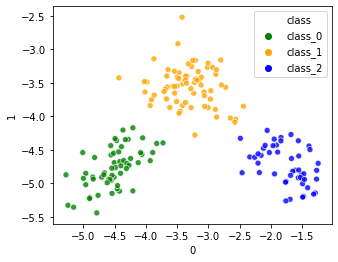

In [111]:
plt.figure(figsize=(5, 4))
ax = sns.scatterplot(
    x=0, y=1,
    hue="class",
    palette=['green', 'orange', 'blue'],
    data=x_lda,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

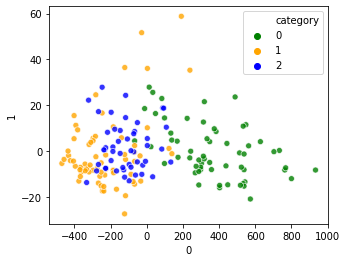

In [115]:
#compare original data, plotted with tsne/PCA
X_tsne = PCA(n_components=2).fit_transform(wine.data)

df_tsne = pd.DataFrame(X_tsne)
df_tsne.columns = [str(c) for c in df_tsne.columns]
df_tsne['category'] = wine.target

plt.figure(figsize=(5, 4))
ax = sns.scatterplot(
    x="0", y="1",
    hue="category",
    palette=['green', 'orange', 'blue'],
    data=df_tsne,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

## Is lda helping with classification?

In [37]:
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [38]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target
scores_regulars=cross_val_score(pipe, X, wine.target, cv=10)
pd.DataFrame(scores_regulars).describe()

,0
count,10.000000
mean,0.978070
std,0.028324
min,0.944444
25%,0.945175
50%,1.000000
75%,1.000000
max,1.000000


In [39]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

X = df_lda.drop('class', axis=1)
y = wine.target
scores_regulars=cross_val_score(pipe, X, wine.target, cv=10)
pd.DataFrame(scores_regulars).describe()

,0
count,10.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0
